In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

# --- Parte 1: Função para Processar os Arquivos --- #
def clean_hora(x):
    """Função auxiliar para extrair apenas a parte do horário, removendo eventuais
    informações do tipo '01/01/1900' que possam estar contidas nos dados."""
    s = str(x).strip()
    if "1900" in s:
        parts = s.split()
        if len(parts) > 1:
            return parts[-1]  # retorna o horário (último token)
        else:
            return s.replace("01/01/1900", "").strip()
    else:
        return s

def process_file(filename):
    """Lê um arquivo Excel e retorna um DataFrame ordenado com a coluna 'datetime'
    formada a partir das colunas 'dia' e 'hora' (com limpeza)."""
    df = pd.read_excel(filename)

    # Aplica a limpeza na coluna "hora"
    df['hora'] = df['hora'].apply(clean_hora)

    # Converte 'dia' para string e combina com 'hora'
    df['dia'] = df['dia'].astype(str)
    df['datetime'] = pd.to_datetime(df['dia'] + ' ' + df['hora'], errors='coerce')
    df = df.dropna(subset=['datetime']).sort_values('datetime').reset_index(drop=True)
    return df

# Lista dos arquivos (ajuste o caminho, se necessário)
arquivos = ["casa1PM.xlsx", "casa2PM.xlsx", "casa3PM.xlsx", "casa4PM.xlsx"]

# Processa cada arquivo e adiciona uma coluna identificadora (nome do arquivo)
dfs = []
for arq in arquivos:
    df_arq = process_file(arq)
    df_arq['casa'] = arq
    dfs.append(df_arq)

# Concatena todos os DataFrames para análise agregada
dados = pd.concat(dfs, ignore_index=True)

# --- Parte 2: Definindo as Variáveis de Interesse para as Frações --- #
variaveis = {
    "PM1": {"cin": "cinPM1", "cout": "coutPM1"},
    "PM2.5": {"cin": "cinPM25", "cout": "coutPM25"},
    "PM10": {"cin": "cinPM10", "cout": "coutPM10"}
}

            casa fração            datetime  cinPM25  edge_class
0   casa1PM.xlsx    PM1 2022-05-03 15:00:00      6.1    baseline
1   casa1PM.xlsx    PM1 2022-05-03 16:00:00      7.0    baseline
2   casa1PM.xlsx    PM1 2022-05-03 17:00:00      7.3    baseline
3   casa1PM.xlsx    PM1 2022-05-03 18:00:00      7.6    baseline
4   casa1PM.xlsx    PM1 2022-05-03 19:00:00      8.0    baseline
5   casa1PM.xlsx    PM1 2022-05-03 20:00:00      8.4    baseline
6   casa1PM.xlsx    PM1 2022-05-03 21:00:00     25.3      rising
7   casa1PM.xlsx    PM1 2022-05-03 22:00:00      7.5  whole_edge
8   casa1PM.xlsx    PM1 2022-05-03 23:00:00      4.8  whole_edge
9   casa1PM.xlsx    PM1 2022-05-04 00:00:00      2.7    baseline
10  casa1PM.xlsx    PM1 2022-05-04 01:00:00      2.6    baseline
11  casa1PM.xlsx    PM1 2022-05-04 02:00:00      4.2    baseline
12  casa1PM.xlsx    PM1 2022-05-04 03:00:00      4.2    baseline
13  casa1PM.xlsx    PM1 2022-05-04 04:00:00      4.1    baseline
14  casa1PM.xlsx    PM1 2

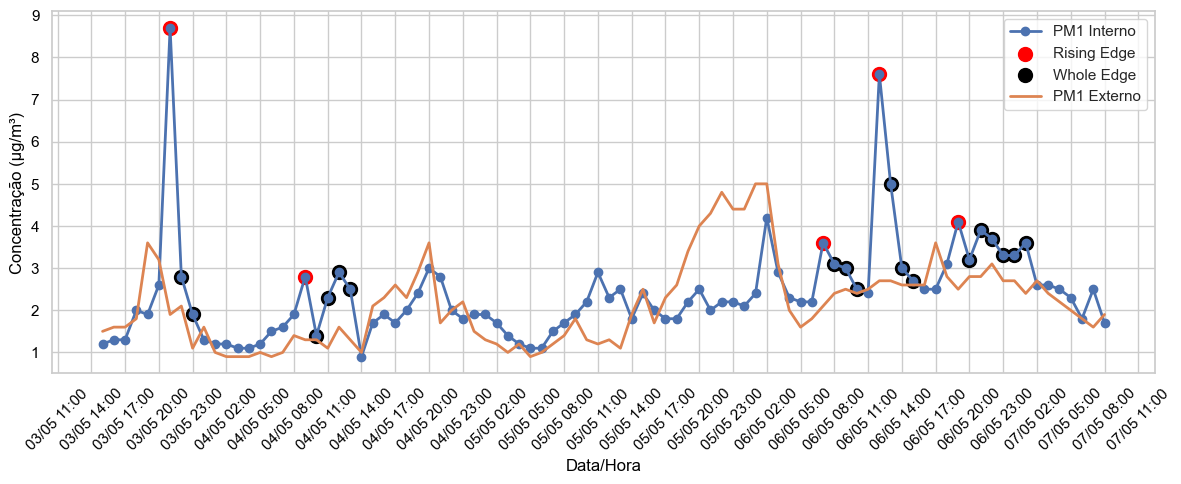

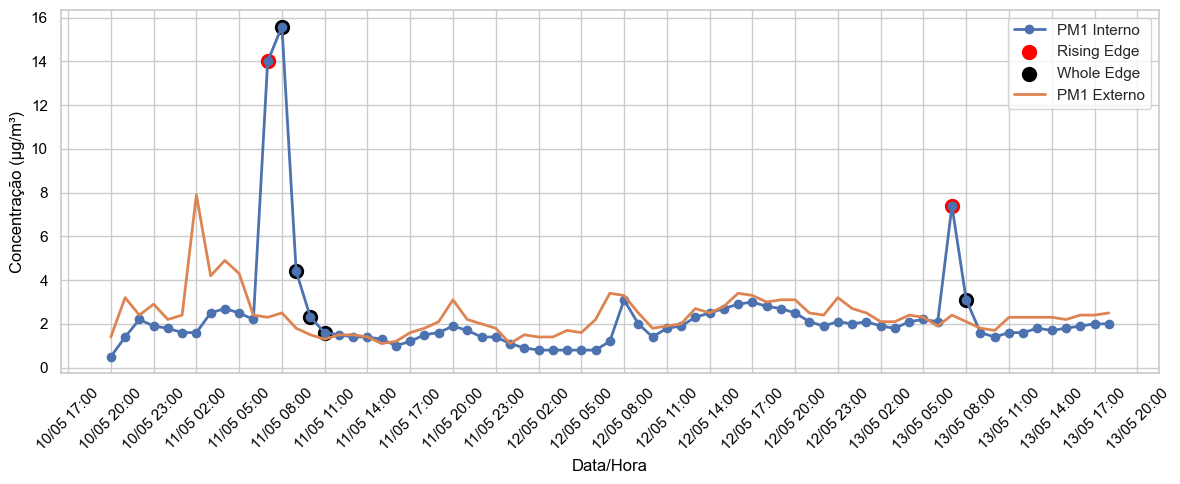

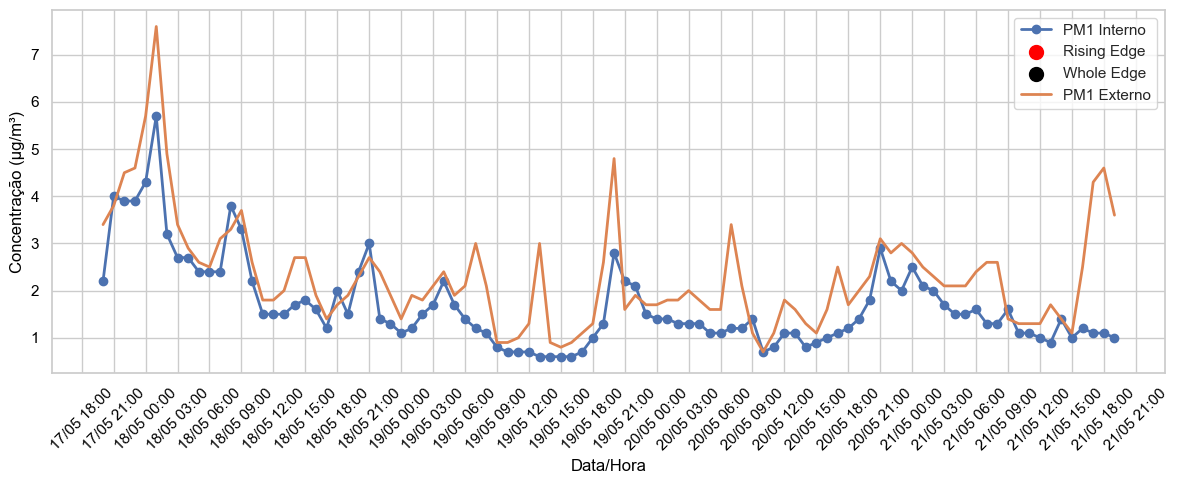

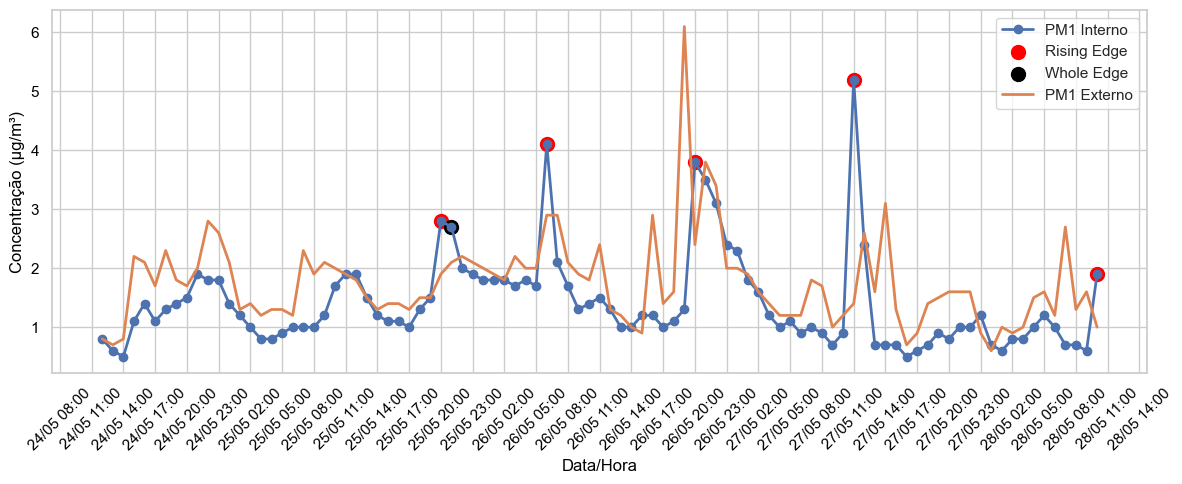

In [3]:

# --- Parte 3: Implementando o Modelo Base de Allen et al. (2003) ---
def classify_edges(df, cin_col, cout_col, T_rise=0.75, T_drop_ratio=0.25):
    """
    Classifica os eventos na série temporal com base no aumento repentino
    (rising edge) e marca os pontos subsequentes como parte do mesmo pico
    ("whole edge") enquanto a concentração interna se mantiver elevada.

    Parâmetros:
    - df: DataFrame com os dados já ordenados por 'datetime'.
    - cin_col: Nome da coluna de concentração interna.
    - cout_col: Nome da coluna de concentração externa.
    - T_rise: Diferença mínima (em µg/m³) entre o valor atual e o anterior para
    identificar um "rising edge".
    - T_drop_ratio: Fator multiplicativo para definir o fim de um evento. Se o valor
      atual cair para menos que (valor anterior * T_drop_ratio) ou se a concentração interna
    ficar igual ou inferior à externa, o pico é encerrado.

    Retorna:
    - DataFrame com uma nova coluna 'edge_class' com valores:
    "baseline" (sem evento), "rising" (início de pico) e "whole_edge" (ponto do fim do evento).
    """
    df = df.copy()
    df['edge_class'] = "baseline"
    n = len(df)
    i = 1  # começamos do segundo ponto, pois precisamos de t-1
    while i < n:
        delta = df.iloc[i][cin_col] - df.iloc[i-1][cin_col]
        # Se o aumento ultrapassa o limiar e o indoor for maior que o outdoor, marcamos como rising
        if delta > T_rise and df.iloc[i][cin_col] > df.iloc[i][cout_col] and df.iloc[i][cin_col] / df.iloc[i][cout_col] >= 1.2:
            df.at[df.index[i], 'edge_class'] = "rising"
            # Agora, identificamos os pontos seguintes que fazem parte do mesmo evento
            j = i + 1
            while j < n:
                # Se cair abaixo de um fator ou atingir níveis parecidos com o outdoor, encerra o pico.
                if df.iloc[j][cin_col] < df.iloc[j-1][cin_col] * T_drop_ratio or df.iloc[j][cin_col] <= df.iloc[j][cout_col]:
                    break
                else:
                    df.at[df.index[j], 'edge_class'] = "whole_edge"
                j += 1
            i = j  # pula para o próximo evento
        else:
            i += 1
    return df

# --- Parte 4: Aplicando o Modelo para Cada Fração em Cada Casa ---
resultados = []  # para armazenar os resultados
for casa in dados['casa'].unique():
    df_casa = dados[dados['casa'] == casa].copy()
    for frac, cols in variaveis.items():
        # Aplicar a função de classificação para a fração corrente
        df_class = classify_edges(df_casa, cols["cin"], cols["cout"], T_rise=0.75, T_drop_ratio=0.25)
        df_class['fração'] = frac
        resultados.append(df_class)

# Concatena os resultados
df_resultado = pd.concat(resultados, ignore_index=True)

# Exibe as primeiras linhas do resultado com as classificações
print(df_resultado[['casa', 'fração', 'datetime', variaveis["PM2.5"]["cin"], "edge_class"]].head(20))

# --- Parte 5: Visualização dos Eventos Classificados para PM2.5 como Exemplo ---
frac_exemplo = "PM1"
for casa in df_resultado['casa'].unique():
    df_plot = df_resultado[(df_resultado['casa'] == casa) & (df_resultado['fração'] == frac_exemplo)]
    plt.figure()
    plt.plot(df_plot['datetime'], df_plot[variaveis[frac_exemplo]["cin"]], label="PM1 Interno", marker="o", linestyle="-", lw=2)
    # Destacar os eventos de rising e whole_edge com cores diferenciadas
    rising = df_plot[df_plot['edge_class'] == "rising"]
    whole_edge = df_plot[df_plot['edge_class'] == "whole_edge"]
    plt.scatter(rising['datetime'], rising[variaveis[frac_exemplo]["cin"]], color='red', label="Rising Edge", s=100)
    plt.scatter(whole_edge['datetime'], whole_edge[variaveis[frac_exemplo]["cin"]], color='black', label="Whole Edge", s=100)
    plt.plot(df_plot['datetime'], df_plot[variaveis[frac_exemplo]["cout"]], label="PM1 Externo", linestyle="-", lw=2)
    #plt.ylim(0,16)
    plt.xlabel("Data/Hora", color='black')
    plt.ylabel("Concentração (µg/m³)", color='black')
    #plt.title(f"{casa} - Eventos Classificados para {frac_exemplo}")
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M'))
    plt.xticks(rotation=45, color='black')
    plt.yticks(color='black')
    plt.legend()
    #df_plot.drop(columns=['cin','cout'])
    plt.tight_layout()
    plt.show()

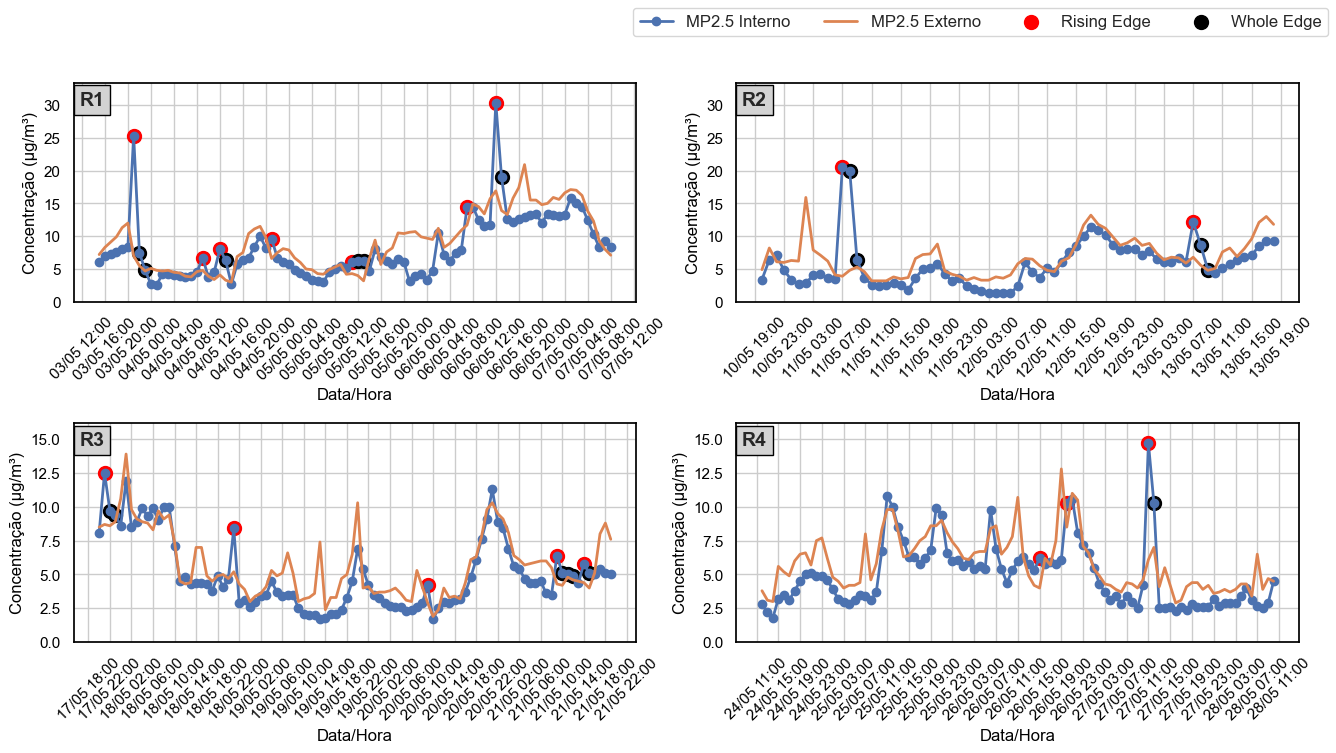

In [ ]:
# Assumindo que variaveis e df_resultado já foram definidos anteriormente

frac_exemplo = "PM2.5"
casas = df_resultado['casa'].unique()

# Mapeamento das residências (de acordo com os nomes reais dos arquivos)
label_residencias = {
    'casa1PM.xlsx': 'R1',
    'casa2PM.xlsx': 'R2',
    'casa3PM.xlsx': 'R3',
    'casa4PM.xlsx': 'R4'
}

fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=False)
axs = axs.flatten()

# Descobrir limite Y comum para casa1 e casa2
df_casa1 = df_resultado[(df_resultado['casa'] == 'casa1PM.xlsx') & (df_resultado['fração'] == frac_exemplo)]
df_casa2 = df_resultado[(df_resultado['casa'] == 'casa2PM.xlsx') & (df_resultado['fração'] == frac_exemplo)]
ymax_casa1_2 = max(
    df_casa1[variaveis[frac_exemplo]["cin"]].max(),
    df_casa1[variaveis[frac_exemplo]["cout"]].max(),
    df_casa2[variaveis[frac_exemplo]["cin"]].max(),
    df_casa2[variaveis[frac_exemplo]["cout"]].max()
)
# Descobrir limite Y comum para casa3 e casa4
df_casa3 = df_resultado[(df_resultado['casa'] == 'casa3PM.xlsx') & (df_resultado['fração'] == frac_exemplo)]
df_casa4 = df_resultado[(df_resultado['casa'] == 'casa4PM.xlsx') & (df_resultado['fração'] == frac_exemplo)]
ymax_casa3_4 = max(
    df_casa3[variaveis[frac_exemplo]["cin"]].max(),
    df_casa3[variaveis[frac_exemplo]["cout"]].max(),
    df_casa4[variaveis[frac_exemplo]["cin"]].max(),
    df_casa4[variaveis[frac_exemplo]["cout"]].max()
)

for i, casa in enumerate(casas):
    df_plot = df_resultado[(df_resultado['casa'] == casa) & (df_resultado['fração'] == frac_exemplo)]
    ax = axs[i]

    # Plot Interno e Externo
    ax.plot(df_plot['datetime'], df_plot[variaveis[frac_exemplo]["cin"]],
            label="MP2.5 Interno", marker="o", linestyle="-", lw=2)

    ax.plot(df_plot['datetime'], df_plot[variaveis[frac_exemplo]["cout"]],
            label="MP2.5 Externo", linestyle="-", lw=2)

    # Eventos destacados
    rising = df_plot[df_plot['edge_class'] == "rising"]
    whole_edge = df_plot[df_plot['edge_class'] == "whole_edge"]

    ax.scatter(rising['datetime'], rising[variaveis[frac_exemplo]["cin"]],
               color='red', label="Rising Edge", s=100)
    ax.scatter(whole_edge['datetime'], whole_edge[variaveis[frac_exemplo]["cin"]],
               color='black', label="Whole Edge", s=100)

    # Eixos e ticks
    ax.set_xlabel("Data/Hora", color='black')
    ax.set_ylabel("Concentração (µg/m³)", color='black')
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M'))
    ax.tick_params(axis='x', rotation=45, labelcolor='black', direction='out', length=6)
    ax.tick_params(axis='y', labelcolor='black', direction='out', length=6)
    
    for spine in ['bottom', 'left', 'right', 'top']:
            ax.spines[spine].set_color('black')
    
    # Padronizar eixo y para casas 1 e 2
    if i in [0, 1]:
        ax.set_ylim(0, ymax_casa1_2 * 1.1)  # pequeno espaço acima do maior valor
    # Padronizar eixo y para casas 3 e 4
    if i in [2, 3]:
        ax.set_ylim(0, ymax_casa3_4 * 1.1)
    
    # Texto com R1, R2, etc.
    ax.text(0.01, 0.90, label_residencias[casa], transform=ax.transAxes,
            fontsize=14, fontweight='bold', bbox=dict(facecolor='lightgrey', edgecolor='black'))

# Legenda global
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=4, fontsize=12)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.92])
plt.show()
